In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt
import subprocess

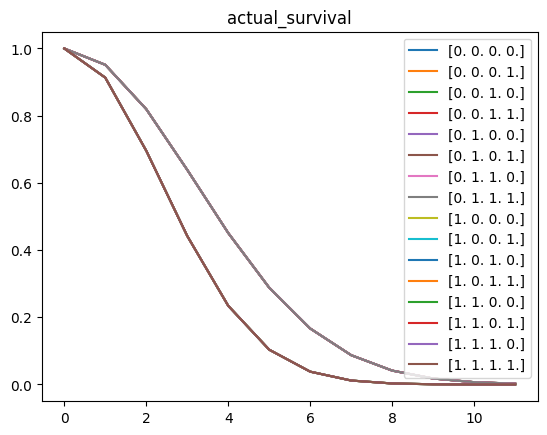

cens_calc: 0.0     
t_mean: 3.93     
t_max: 11.0
hazard rate 1 [0.54431 1.08862 1.63292]
hazard rate 0 [0.29872 0.59744 0.89617]
HR t-series = [1.82214114 1.82214114 1.82210964]


/tmp/ipykernel_4581/4044894179.py:44: RuntimeWarning: invalid value encountered in divide
  HR_unique = hz_unique[1]/hz_unique[0]


In [15]:
OUTPUTS = "outputs"
ALPHA = 2 
# ALPHA_F = "1"
VAR_CLASS = [2,2,3,4]
VAR_PROB = [0.2, 0.5, 0.5, 0.2]
LAMBDA = "np.exp(-1.5 + .3*x_mat[:,0] + 0*(x_mat[:,1] + x_mat[:,2] + x_mat[:,3]))"
N = 200
# T = 30
X_VARS = 4
CENS_SCALE = 5# 40
CENS_IND = False

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                a = ALPHA,
                # alpha_f = ALPHA_F,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

# get unique x_mat
x_unique = np.unique(x_mat, return_index=True)
sv_unique = sv_mat[x_unique[1],:]
hz_unique = np.round(hz_mat[x_unique[1],:],5) 

HR_unique = hz_unique[1]/hz_unique[0]
# HR_times = np.arange(0,T,np.floor(T/4), dtype="int")
HR_times = np.array((np.ceil(T.shape[0]/4) * np.array([1,2,3])), dtype="int")
print(f"hazard rate 1 {hz_unique[1][HR_times]}")
print(f"hazard rate 0 {hz_unique[0][HR_times]}")
print(f"HR t-series = {HR_unique[HR_times]}")

In [29]:
y_sk = ssf.get_y_sklearn(status, t_event)
y_sk2 = ssf.get_y_sklearn(status, np.ceil(t_event/2))


In [36]:
y_sk["Survival_in_days"].max()

11.0

In [30]:
kpm = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm2 = sks.nonparametric.kaplan_meier_estimator(y_sk2["Status"], y_sk2["Survival_in_days"])

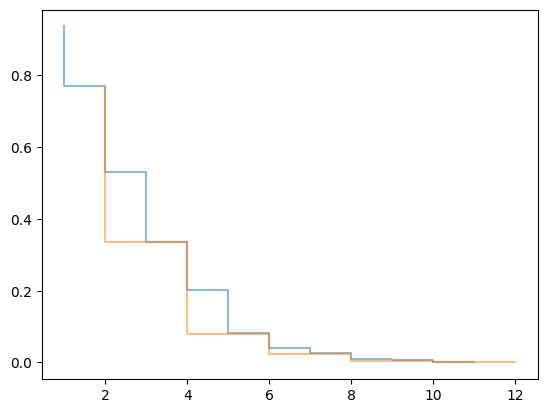

In [39]:
plt.step(kpm[0], kpm[1]+0.001, alpha=0.5)
plt.step(kpm2[0]*2, kpm2[1], alpha=0.5)


When the time factor is reduced by a number, the kpm will align at the reduced time points. Scaling down is a valid way to reduce computed timepoints